<a href="https://colab.research.google.com/github/ladrianx/proyectos/blob/main/nn_retro_stf_p4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El lag con mayor valor absoluto es: 3 con un valor de: -0.08012288 
El lag más significativo es: 3 
Evaluación final con el último dato...
Predicción del último día: 0.003704722 
Valor real del último día: 0.01249441 
Error absoluto en el último día: 0.008789683 


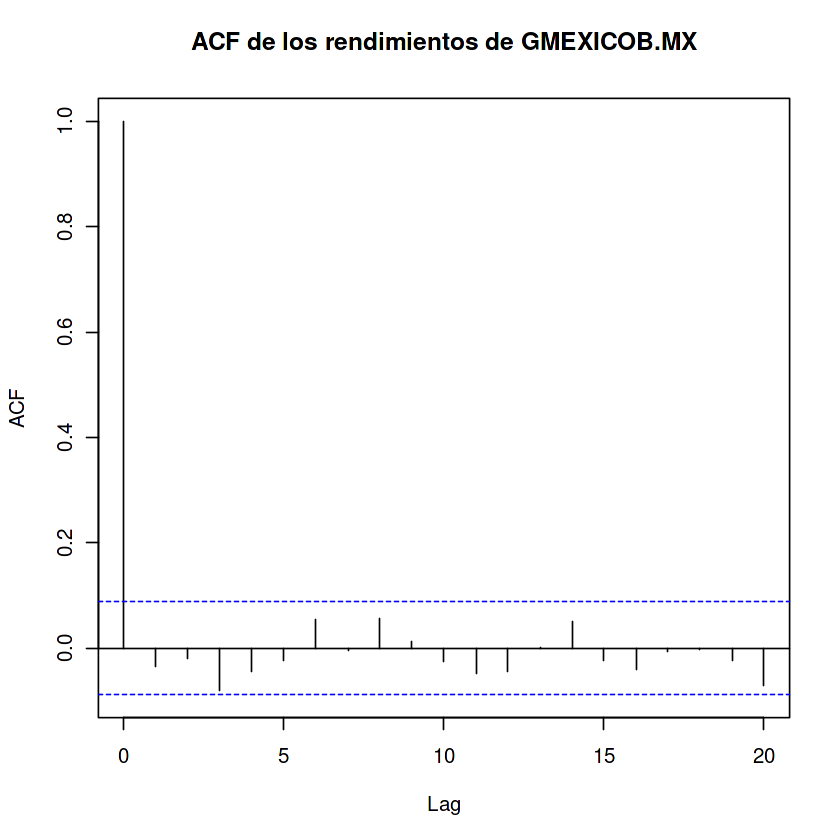

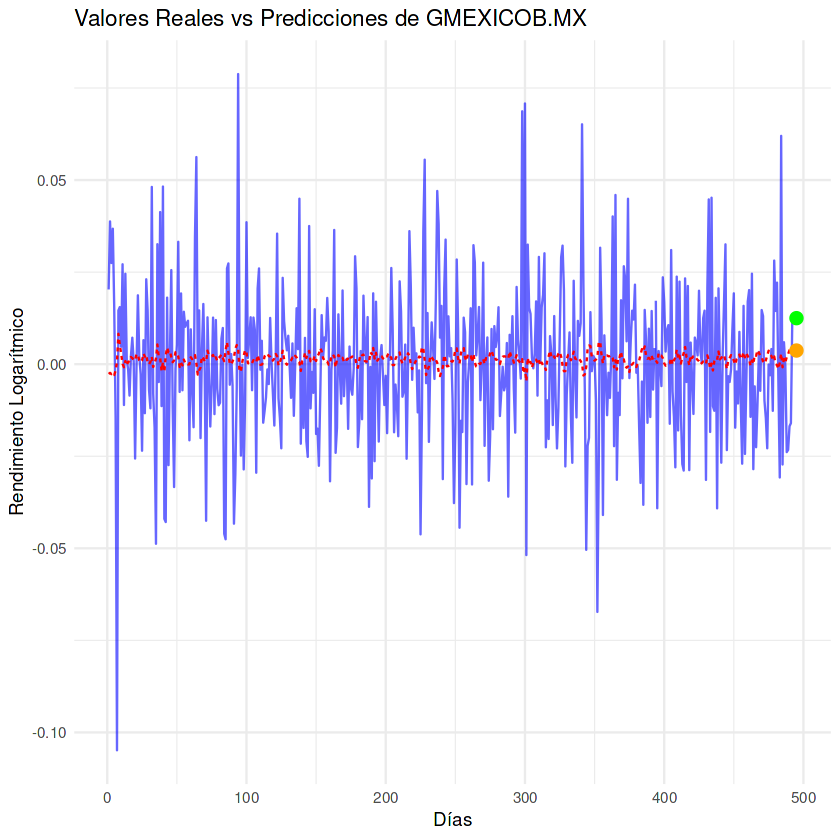

In [ ]:
################ Cargar librerías necesarias
library(quantmod)
library(tidyr)
library(dplyr)
library(tensorflow)
library(keras)
library(ggplot2)

# Función para obtener los datos de Yahoo Finance
get_yahoo_data <- function(ticker, start_date, end_date) {
  data <- getSymbols(ticker, src = 'yahoo', from = start_date, to = end_date, auto.assign = FALSE)
  return(data)
}

# Calcular los rendimientos logarítmicos
calculate_returns <- function(data) {
  log_returns <- na.omit(diff(log(Cl(data))))  # Diferencia logarítmica de precios de cierre
  return(log_returns)
}

# Generar los datos con lags para la red neuronal
generate_lagged_data <- function(data, lag) {
  X <- matrix(NA, nrow = length(data) - lag, ncol = lag)
  Y <- data[(lag + 1):length(data)]

  for (i in 1:(length(data) - lag)) {
    X[i, ] <- data[i:(i + lag - 1)]
  }

  return(list(X = X, Y = Y))
}

# Descargar los datos de Yahoo Finance
ticker <- "GMEXICOB.MX"  # Reemplazar por el ticker de tu interés
start_date <- "2023-01-01"
end_date <- "2024-12-22"
data <- get_yahoo_data(ticker, start_date, end_date)

# Calcular los rendimientos logarítmicos
returns <- calculate_returns(data)

# Calcular la ACF y obtener el lag más significativo
acf_result <- acf(returns, lag.max = 20, plot = TRUE, main = paste("ACF de los rendimientos de", ticker))
lags <- acf_result$lag[-1]  # Excluir el lag 0
acf_values <- acf_result$acf[-1]
max_abs_lag <- which.max(abs(acf_values))
lag_significant <- if (length(lags) > 0) lags[max_abs_lag] else 5  # Si no se encuentra lag, poner 5 como predeterminado

cat("El lag con mayor valor absoluto es:", lags[max_abs_lag], "con un valor de:", acf_values[max_abs_lag], "\n")
cat("El lag más significativo es:", lag_significant, "\n")

# Generar los datos con el lag más significativo
lag <- lag_significant
lagged_data <- generate_lagged_data(returns, lag)

# Verificar las dimensiones de X_train y Y_train
X_train <- lagged_data$X
Y_train <- lagged_data$Y

# Eliminar filas con NA de X_train y Y_train
data_clean <- na.omit(data.frame(X_train, Y_train))  # Eliminar filas con NA en ambas variables

# Extraer los datos limpios después de eliminar NA
X_train_clean <- as.matrix(data_clean[, 1:lag])  # Variables de entrada (primeras "lag" columnas)
Y_train_clean <- data_clean[, (lag + 1)]  # Variable de salida (última columna)

# Dividir los datos en entrenamiento y validación
train_size <- floor(0.8 * nrow(X_train_clean))  # 80% para entrenamiento
X_train_final <- X_train_clean[1:train_size, ]
Y_train_final <- Y_train_clean[1:train_size]
X_val <- X_train_clean[(train_size + 1):nrow(X_train_clean), ]
Y_val <- Y_train_clean[(train_size + 1):length(Y_train_clean)]

# Convertir X_train_final y X_val a arrays para Keras
X_train_final <- array(X_train_final, dim = c(nrow(X_train_final), lag, 1))  # Convertir a la forma que Keras espera
X_val <- array(X_val, dim = c(nrow(X_val), lag, 1))

# Convertir Y_train_final y Y_val a arrays para Keras
Y_train_final <- array(Y_train_final, dim = c(length(Y_train_final), 1))
Y_val <- array(Y_val, dim = c(length(Y_val), 1))

# Crear el modelo de red neuronal con Keras, donde el número de neuronas de entrada es "lag" y
# el número de neuronas en la capa oculta es "lag - 1"
model <- keras_model_sequential() %>%
  layer_lstm(units = lag - 1, input_shape = c(lag, 1), return_sequences = FALSE) %>%
  layer_dense(units = 1)

# Compilar el modelo
model %>% compile(
  loss = 'mean_squared_error',
  optimizer = optimizer_adam(),
  metrics = c('mean_absolute_error')
)

# Entrenar el modelo
history <- model %>% fit(X_train_final, Y_train_final, epochs = 10, batch_size = 32,
                         validation_data = list(X_val, Y_val), verbose = 1)

# Evaluar el modelo con el último dato (out-of-sample)
cat("Evaluación final con el último dato...\n")
X_test <- X_train_clean[nrow(X_train_clean), , drop = FALSE]  # Usar el último dato para la predicción
Y_test <- Y_train_clean[length(Y_train_clean)]  # El valor correspondiente

# Hacer la predicción
pred <- model %>% predict(X_test)

# Mostrar la predicción y el valor real
cat("Predicción del último día:", pred, "\n")
cat("Valor real del último día:", Y_test, "\n")

# Calcular el error para el último día
error_last_day <- abs(Y_test - pred)
cat("Error absoluto en el último día:", error_last_day, "\n")

# Graficar los resultados: valores reales vs predicciones de validación y entrenamiento
# Preparar los datos de entrenamiento, validación y predicción
train_pred <- model %>% predict(X_train_final)
val_pred <- model %>% predict(X_val)

# Graficar
df_train <- data.frame(Dia = 1:length(Y_train_final), Real = Y_train_final, Prediccion = train_pred)
df_val <- data.frame(Dia = (train_size + 1):(train_size + length(Y_val)), Real = Y_val, Prediccion = val_pred)
df_test <- data.frame(Dia = length(returns), Real = Y_test, Prediccion = pred)

ggplot() +
  geom_line(data = df_train, aes(x = Dia, y = Real), color = 'blue', alpha = 0.6) +
  geom_line(data = df_train, aes(x = Dia, y = Prediccion), color = 'red', linetype = 'dashed') +
  geom_line(data = df_val, aes(x = Dia, y = Real), color = 'blue', alpha = 0.6) +
  geom_line(data = df_val, aes(x = Dia, y = Prediccion), color = 'red', linetype = 'dashed') +
  geom_point(data = df_test, aes(x = Dia, y = Real), color = 'green', size = 3) +
  geom_point(data = df_test, aes(x = Dia, y = Prediccion), color = 'orange', size = 3) +
  labs(title = paste("Valores Reales vs Predicciones de", ticker),
       x = "Días", y = "Rendimiento Logarítmico") +
  theme_minimal() +
  scale_color_manual(values = c("blue", "red", "green", "orange"))
